# Comparing Additional Training and Testing Runs
Additional training runs were completed. Note that training runs >=2 were run for 20 Epochs, whereas 0&1 were run for 10.

In [26]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np

from repeating_classifier_training_utils import *

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [27]:
tia_path = '/data/WatChMaL/data/Best_ResNet18_Model/'
dump_dir = '/home/cmacdonald/CNN/dumps/'
repeat_path_1 = os.path.join(dump_dir,'20200506_104330')
repeat_path_2 = os.path.join(dump_dir,'20200521_134726')
repeat_path_3 = os.path.join(dump_dir,'20200522_145528')
repeat_path_4 = os.path.join(dump_dir,'20200522_153524')
repeat_path_5 = os.path.join(dump_dir,'20200525_110037')
paths = list([tia_path,repeat_path_1,repeat_path_2,repeat_path_3,repeat_path_4,repeat_path_5])
npz_path = os.path.join(os.getcwd(),'Index_Storage')
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

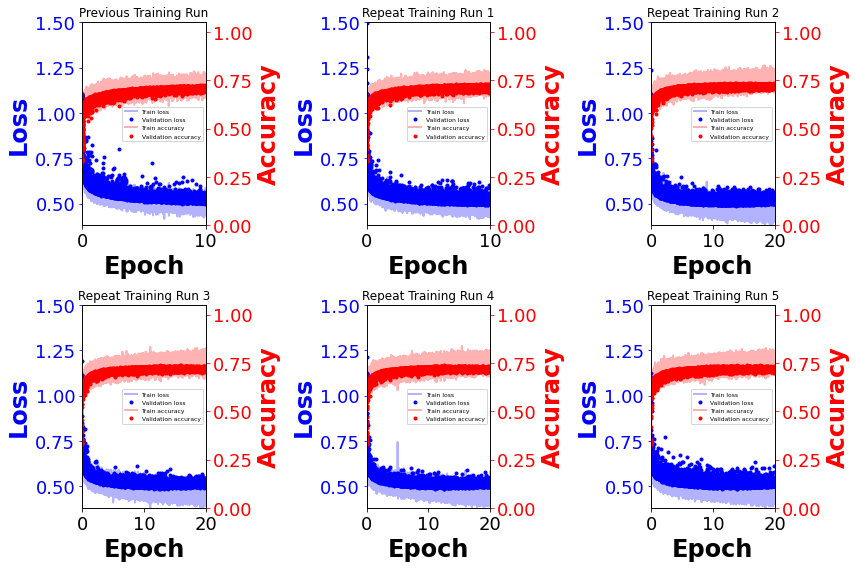

In [4]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],leg_font=6)

## Plot Training History, Where Best Models Were Saved

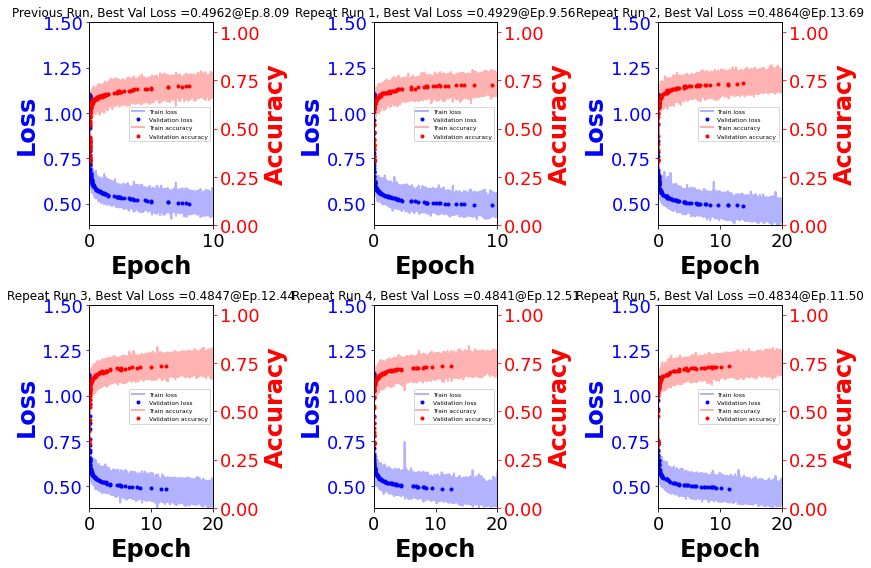

In [5]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)],best_only=True,leg_font=6)

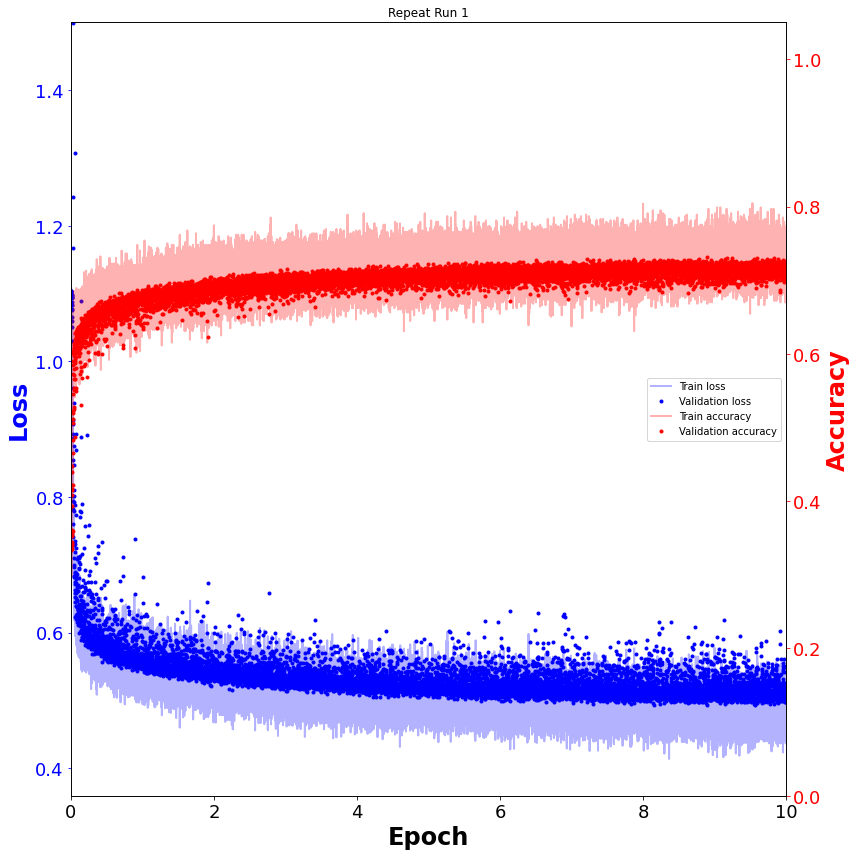

In [6]:
fig = disp_multiple_learn_hist([paths[1]],losslim=1.5,titles=['Repeat Run 1'])

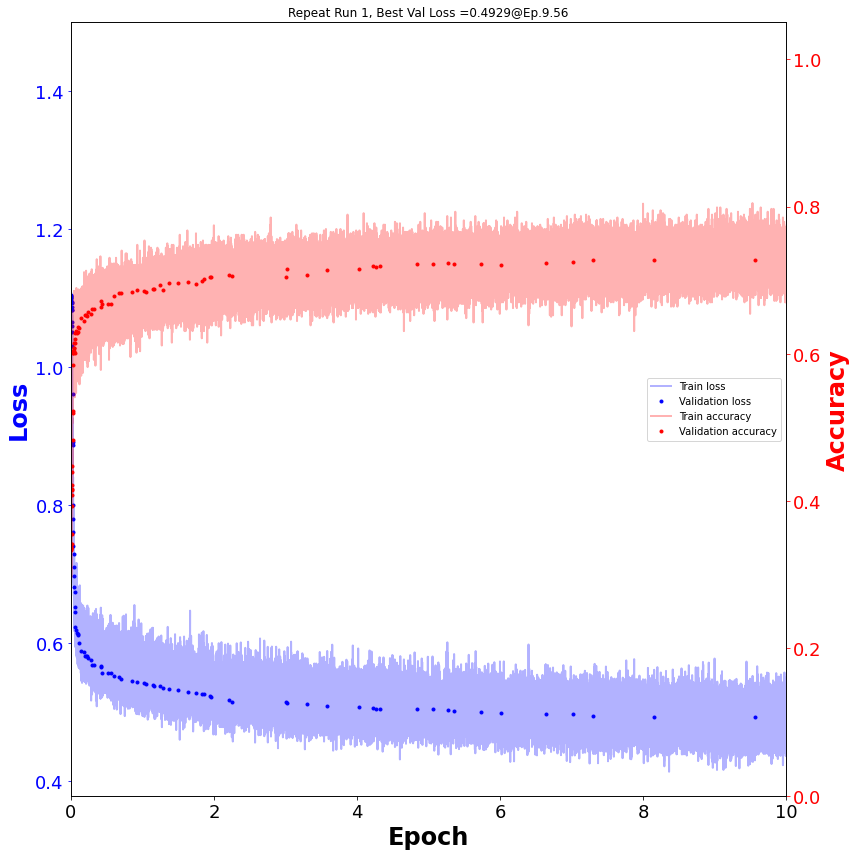

In [7]:
fig = disp_multiple_learn_hist([paths[1]],losslim=1.5,titles=['Repeat Run 1'],best_only=True)

## Plot Confusion Matrices

In [5]:
paths[0] =  "/home/cmacdonald/CNN/dumps/20200519_152505" #this was the test I ran with Tia's pretrained weights, but with sequential dataloader
paths[1] =  "/home/cmacdonald/CNN/dumps/20200511_151728"
test_output = [load_test_output(os.path.join(loc,'test_validation_iteration_dump.npz'),npz_path) for loc in paths]

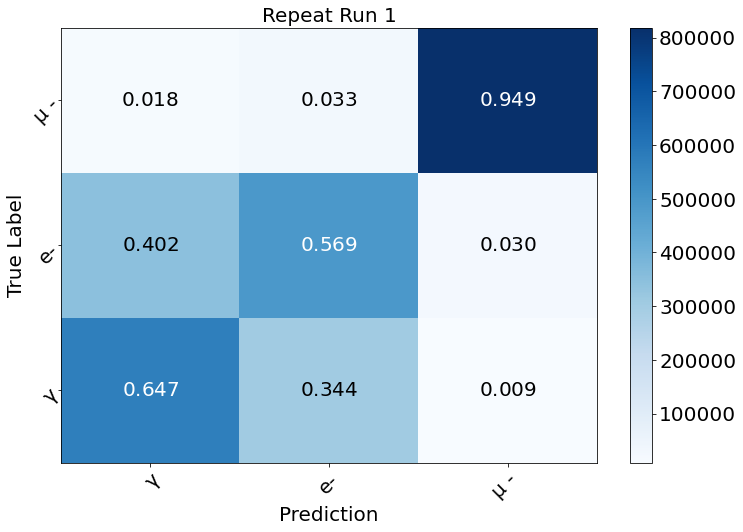

In [6]:
repeat_1 = test_output[2]
fig = plot_confusion_matrix(repeat_1['filtered_labels'],repeat_1['filtered_predictions'],['\u03B3','e-','\u03BC -'],title='Repeat Run 1')

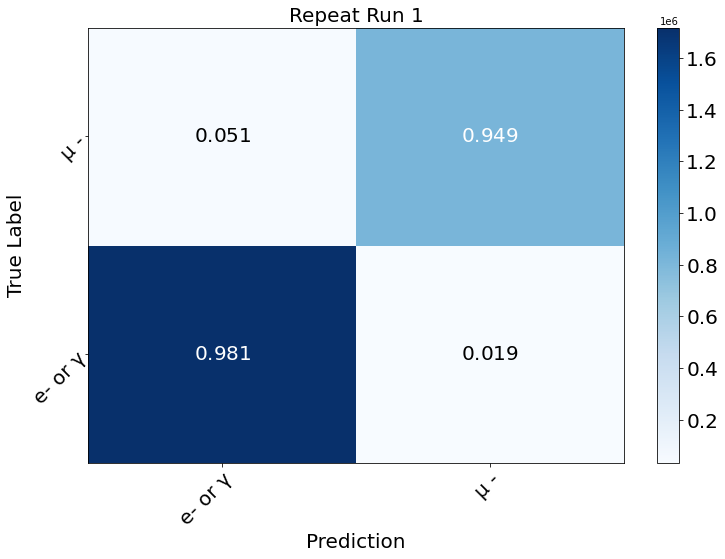

In [10]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict,
                                                                 predictions = repeat_1['filtered_predictions'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title='Repeat Run 1')

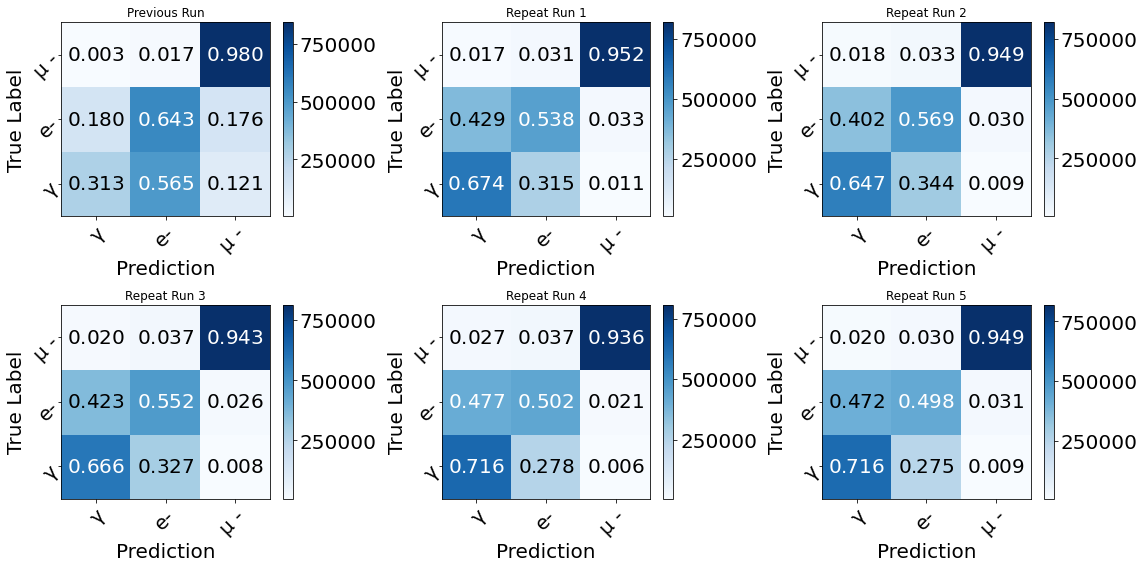

In [11]:
fig = plot_multiple_confusion_matrix([output['filtered_labels'] for output in test_output], [output['filtered_predictions'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)])

## ROC Curves

In [12]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['filtered_softmaxes'],output['filtered_labels'],
                                'rejection',softmax_index_dict,"e","mu",energies=output['filtered_energies'],) for output in test_output]
                            )

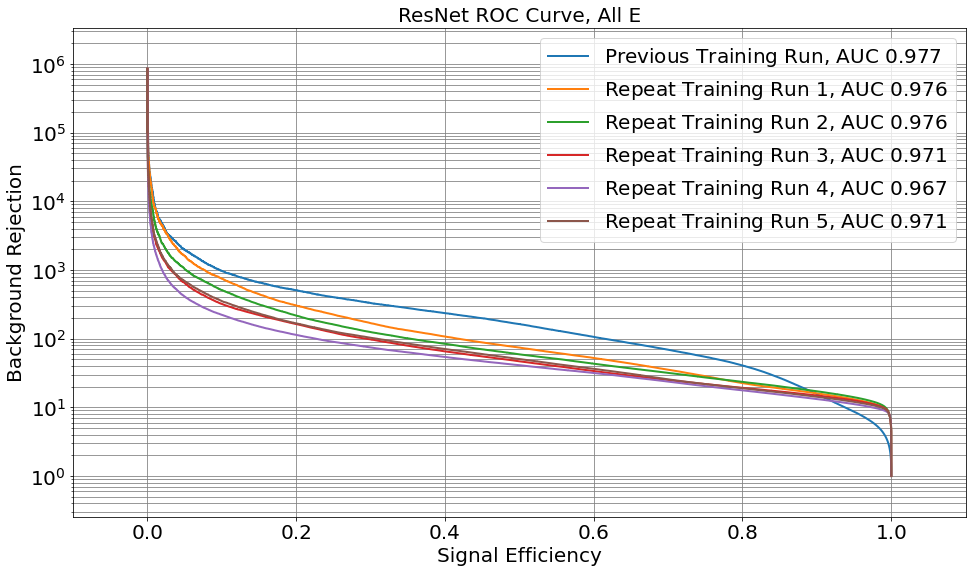

In [13]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [14]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
fprs, tprs, thresholds = zip(*[prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'rejection',softmax_index_dict,"e","mu"),
                                prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'rejection',softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu")]
                            )

In [15]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

e_filenames = f_e['filename']
mu_filenames = f_mu['filename']
gamma_filenames = f_gamma['filename']
e_eventid = f_e['eventid']
mu_eventid = f_mu['eventid']
gamma_eventid = f_gamma['eventid']

e_flag = np.array(f_e['flag'])
e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))[0]
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))[0]
mu_flag = np.array(f_mu['flag'])
mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))[0]
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))[0]
gamma_flag = np.array(f_gamma['flag'])
gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))[0]
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))[0]

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
gamma_nLL = gamma_nLL[gamma_indices]

# Find the raw nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]

e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]

# labels
e_labels_mu = np.ones(e_nLL_diff_mu.shape)
mu_labels_mu = np.ones(mu_nLL_diff_mu.shape)*2
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.ones(mu_nLL_diff_e.shape)*2

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0).astype(int)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0).astype(int)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0).astype(int)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0).astype(int)

fit_fpr, fit_tpr, fit_threshold = roc_curve(labels_e, diff_e,pos_label=1)

fprs = list(fprs)
tprs = list(tprs)
thresholds = list(thresholds)

fprs.append(fit_fpr)
tprs.append(fit_tpr)
thresholds.append(fit_threshold)

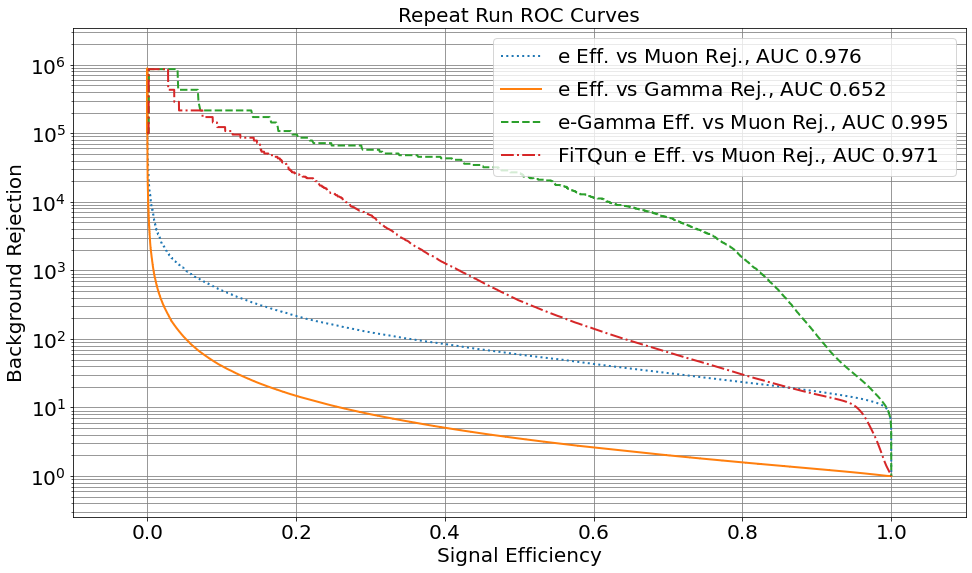

In [16]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e-Gamma Eff. vs Muon Rej.','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'))

In [17]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'fraction',softmax_index_dict,"e","mu"),
                                prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'fraction',
                                              softmax_index_dict, "e","mu")]
                            )

fq_fps, fq_tps, fq_thresholds = binary_clf_curve(labels_e,diff_e,pos_label=softmax_index_dict['e'])
fq_fns = fq_tps[-1] - fq_tps
fq_tns = fq_fps[-1] - fq_fps

tprs+=(fq_tps / (fq_tps + fq_fns),)
fractions+=(fq_tns / (fq_tns + fq_fps),)
fprs+=(fq_fps / (fq_fps + fq_tns),)
thresholds+=(fq_thresholds,)

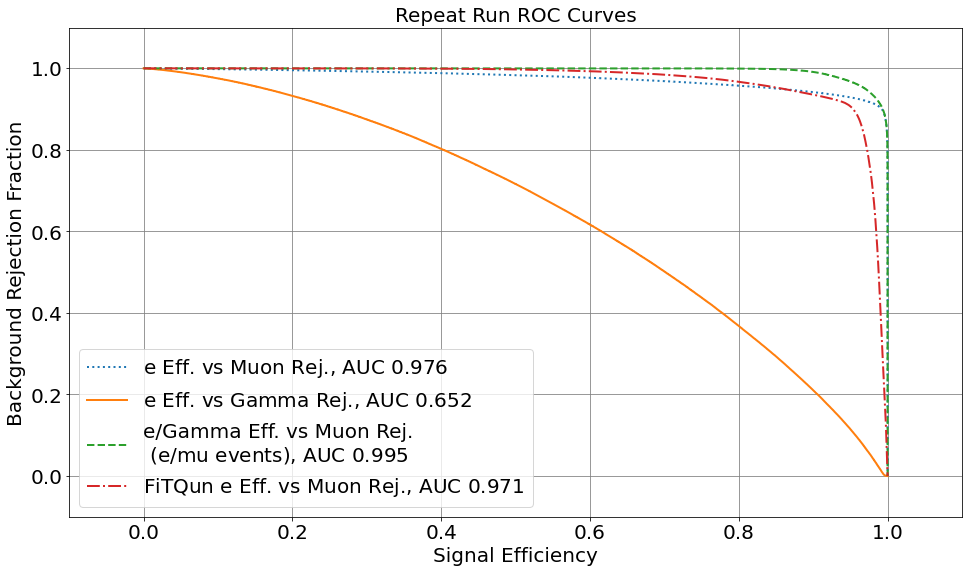

In [18]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e/Gamma Eff. vs Muon Rej. \n (e/mu events)','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left')

## Signal Purity vs Energy At Fixed Efficiency

In [28]:
tia_out = test_output[0]
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(tia_out['filtered_labels'].shape[0])
g_idxs = np.where(tia_out['filtered_labels']==0)[0]
e_idxs = np.where(tia_out['filtered_labels']==1)[0]
m_idxs = np.where(tia_out['filtered_labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(tia_out['filtered_energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(tia_out['filtered_energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(tia_out['filtered_energies'][m_idxs] - MUON_THRESHOLD)

In [20]:
fq_filename_original = (f_gamma['filename'],f_e['filename'],f_mu['filename'])
fq_eventids_original = ( f_gamma['eventid'],f_e['eventid'], f_mu['eventid'])
fq_flag_original = (f_gamma['flag'] ,f_e['flag'],f_mu['flag'])
fq_nll_original = (f_gamma['nLL'],f_e['nLL'],f_mu['nLL'])

n_events = int(reduce(lambda x,y : x+y, list(map(lambda x : x.shape[0],fq_filename_original))))

fq_rootfiles = np.empty(n_events,dtype=object)
fq_eventids = np.zeros(n_events)
fq_flag = np.empty((n_events,2))
fq_nll = np.empty((n_events,2))

fq_mapping_indices = np.load(os.path.join(npz_path,'fq_mapping_idxs.npz'),allow_pickle=True)['arr_0']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
f = h5py.File("/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5", "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
original_labels = np.array(f['labels'])
filtered_labels = original_labels[test_filtered_indices]
fq_failed_idxs = np.load(os.path.join(npz_path,'fq_failed_idxs.npz'), allow_pickle = True)['failed_indices_pointing_to_h5_test_set'].astype(int)
sfiltered_labels = np.delete(filtered_labels, fq_failed_idxs)
sfiltered_eventids = np.delete(filtered_eventids, fq_failed_idxs).astype(int)
sfiltered_rootfiles = np.delete(filtered_rootfiles , fq_failed_idxs)

pbar = ProgressBar(widgets=['Arranging FiTQun Data. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=n_events)
pbar.start()
for i,ptype in enumerate(sfiltered_labels):
    fq_rootfiles[i] = str(fq_filename_original[ptype][fq_mapping_indices[i]])
    fq_eventids[i] = fq_eventids_original[ptype][fq_mapping_indices[i]]
    fq_flag[i] = fq_flag_original[ptype][fq_mapping_indices[i]]
    fq_nll[i] = fq_nll_original[ptype][fq_mapping_indices[i]]
    pbar.update(i)
fq_scores = np.zeros((fq_nll.shape[0],3))
fq_scores[:,0] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,1] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,2] = fq_nll[:,0] - fq_nll[:,1]
fq_labels = sfiltered_labels
pbar.finish()

pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(sfiltered_rootfiles))
pbar.start()
for i in range(len(sfiltered_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == sfiltered_rootfiles[i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == sfiltered_eventids[i]
    pbar.update(i)
pbar.finish()
assert len(sfiltered_rootfiles) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

fq_scores_wflagged = fq_scores
fq_labels_wflagged = fq_labels

flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'))['arr_0']
fq_rootfiles = np.delete(fq_rootfiles, flagged_idxs)
fq_eventids = np.delete(fq_eventids, flagged_idxs)
fq_flag = np.delete(fq_flag, flagged_idxs,0)
fq_nll = np.delete(fq_nll, flagged_idxs,0)
fq_scores = np.delete(fq_scores, flagged_idxs,0)
fq_labels = np.delete(fq_labels, flagged_idxs)

Arranging FiTQun Data. Progress: 100% [0000000000000000000000000] Time: 0:00:17
Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:22


Success! We now have a FiTQun output set in the same order as the h5 test set


In [21]:
collapsed_sm, collapsed_labels = collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict)

/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:92: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


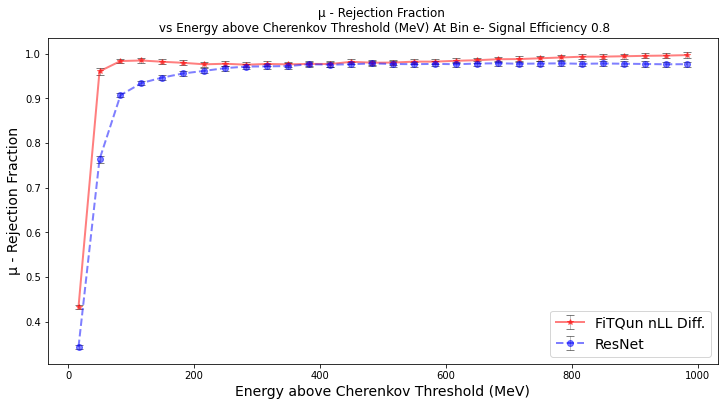

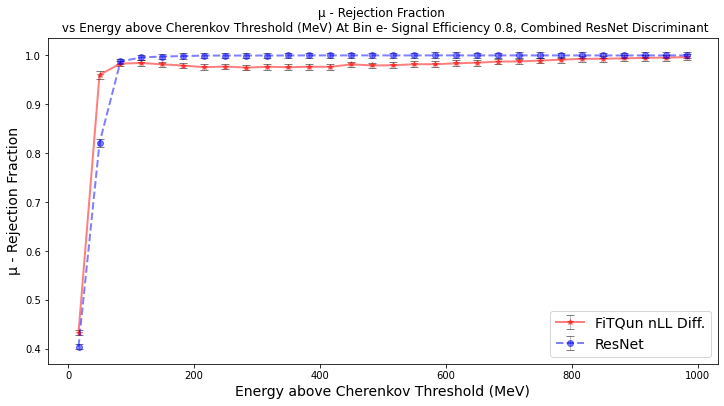

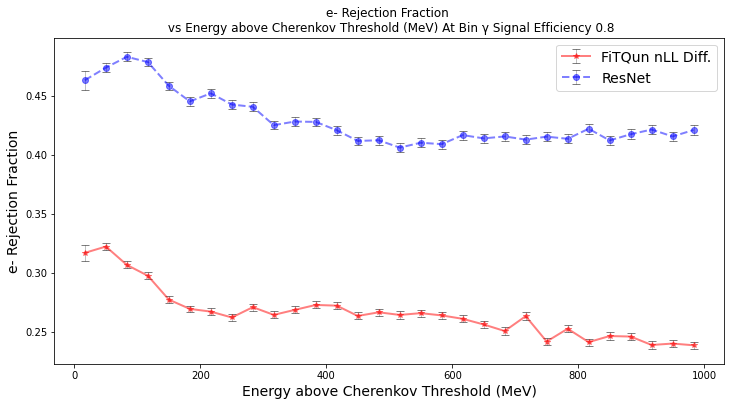

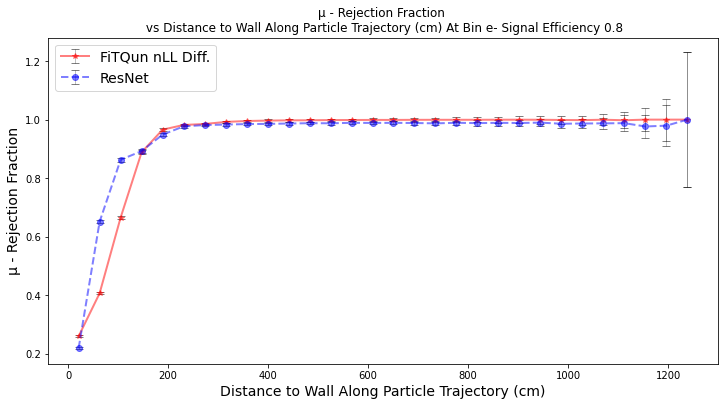

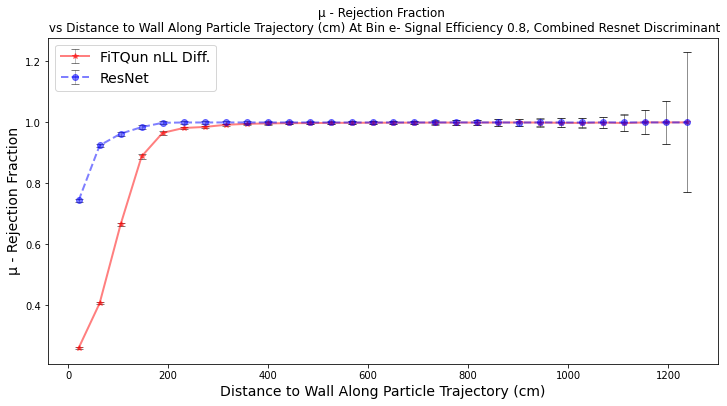

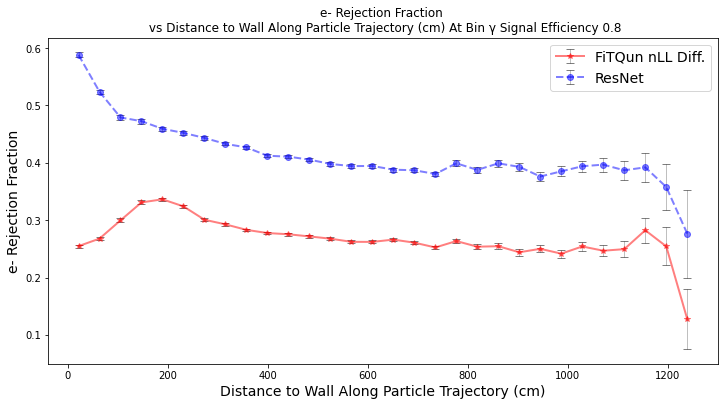

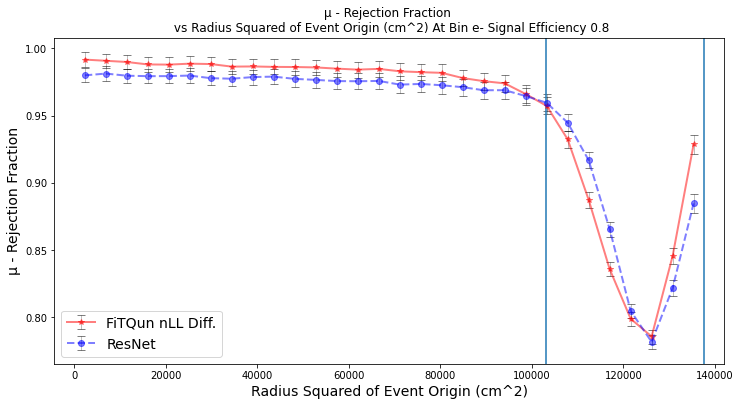

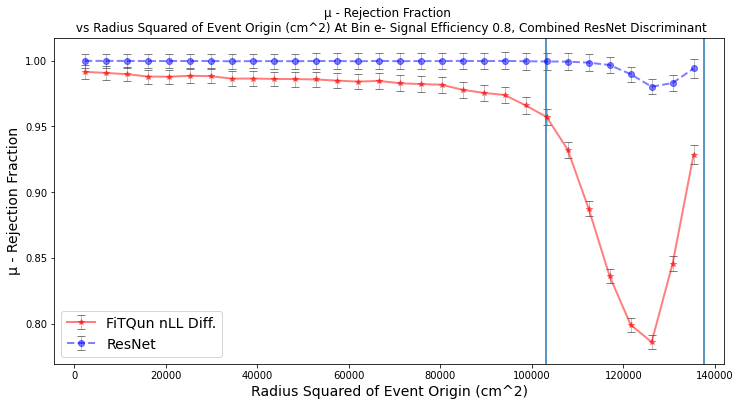

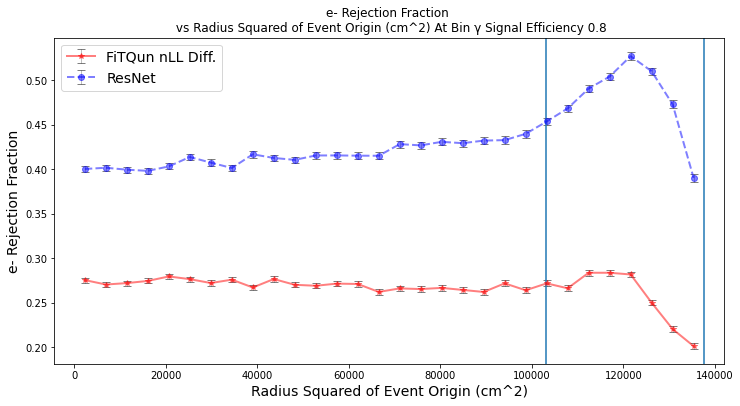

In [74]:
############################# BINNING IN ENERGY ##########################

fig, ax = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax )
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax)
ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

fig7, ax7 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax7 )
plot_binned_performance(collapsed_sm,
            collapsed_labels,
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax7,title_note=', Combined ResNet Discriminant')
ax7.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

fig2, ax2 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='*-',color='r',ax=ax2)
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='o--',color='b' ,ax=ax2)
ax2.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

############################## BINNING IN D-TO-WALL ##############################################

d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall_incl_flagged = np.delete(d_to_wall_incl_all, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall_incl_flagged, fq_flagged_idxs)

fig3, ax3 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax3 )
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection' ,marker='o--',color='b',ax=ax3)
ax3.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

fig8, ax8 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax8 )
plot_binned_performance(collapsed_sm,
            collapsed_labels,
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection' ,marker='o--',color='b',ax=ax8, title_note=', Combined Resnet Discriminant')
ax8.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

fig9, ax9 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='*-',color='r',ax=ax9)
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            d_to_wall,           
            'Distance to Wall Along Particle Trajectory (cm)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='o--',color='b' ,ax=ax9)
ax9.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)

####################################### BINNING IN ORIGIN RADIUS^2 ##################################

test_radius_incl_all = np.load('event_radii.npz')['test_radii']
test_radius_incl_flagged = np.delete(test_radius_incl_all, fq_failed_idxs)
test_radius = np.delete(test_radius_incl_flagged, fq_flagged_idxs)

fig4, ax4 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax4 )
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax4, )
ax4.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
plt.axvline(x=371**2)
plt.axvline(x=321**2)

fig9, ax9 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-',color='r',ax=ax9 )
plot_binned_performance(collapsed_sm,
            collapsed_labels,
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax9, title_note=', Combined ResNet Discriminant')
ax9.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
plt.axvline(x=371**2)
plt.axvline(x=321**2)

fig10, ax10 = plt.subplots(figsize=(12,6))
plot_binned_performance(fq_scores,
            fq_labels,
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='*-',color='r',ax=ax10 )
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'gamma','e',metric='rejection',marker='o--',color='b', ax=ax10)
ax10.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
plt.axvline(x=371**2)
plt.axvline(x=321**2)

In [71]:
output_incl_flagged = load_test_output(os.path.join(paths[2], 'test_validation_iteration_dump.npz'), npz_path, remove_flagged=False)
rawfile = np.load(os.path.join(paths[2], 'test_validation_iteration_dump.npz'), allow_pickle=True)
sm_all = np.concatenate(list([batch_array for batch_array in rawfile['softmax']]))
labels_all = np.concatenate(list([batch_array for batch_array in rawfile['labels']]))

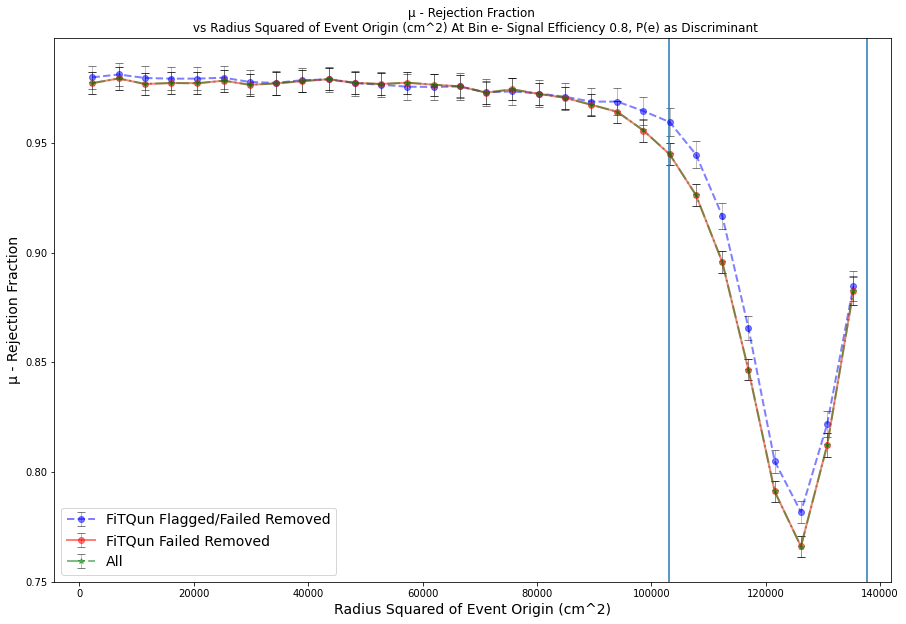

In [81]:
fig4, ax4 = plt.subplots(figsize=(15,10))
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax4, )

plot_binned_performance(output_incl_flagged['s_softmaxes'],
            output_incl_flagged['s_labels'],
            test_radius_incl_flagged**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o-',color='r',ax=ax4)
plot_binned_performance(sm_all,
            labels_all,
            test_radius_incl_all**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-.',color='g',title_note=', P(e) as Discriminant',ax=ax4)
ax4.legend(['FiTQun Flagged/Failed Removed','FiTQun Failed Removed', 'All'],fontsize=14)
plt.axvline(x=371**2)
plt.axvline(x=321**2)

## Plot Classifier Response

### Previous Run

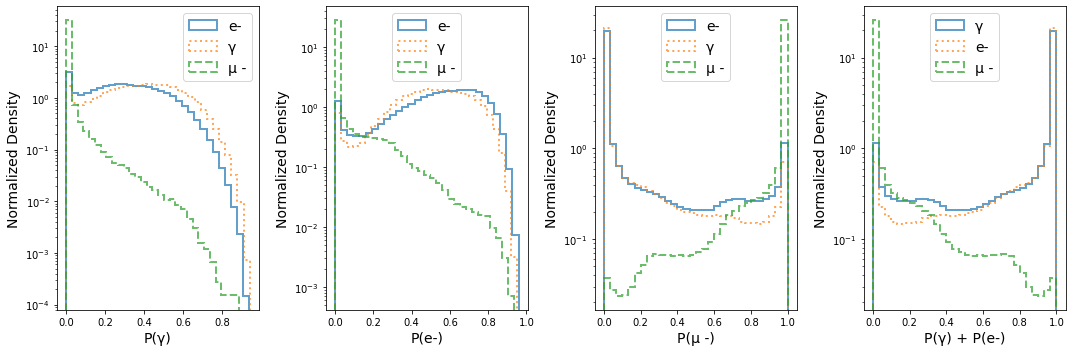

In [49]:
fig = plot_response(tia_out['filtered_softmaxes'], tia_out['filtered_labels'], ['e','gamma','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])

### Repeat Run 2

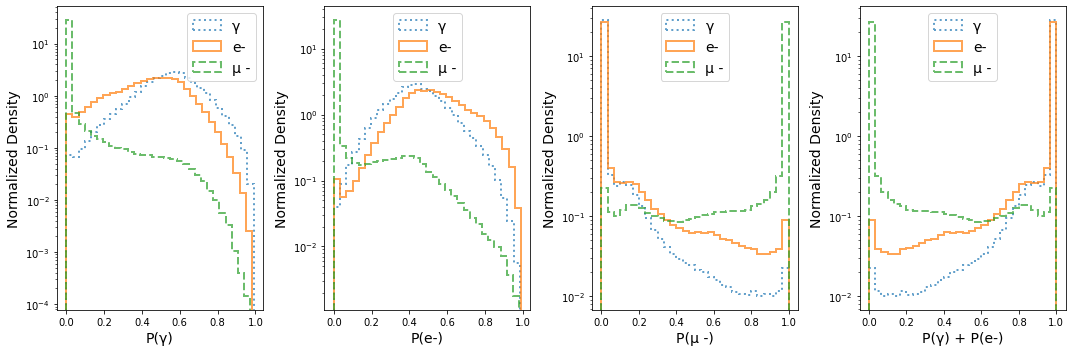

In [43]:
fig=plot_response(test_output[2]['filtered_softmaxes'], test_output[2]['filtered_labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])

In [9]:
ns,bins = np.histogram(shifted_energies, bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(shifted_energies, left_edges)

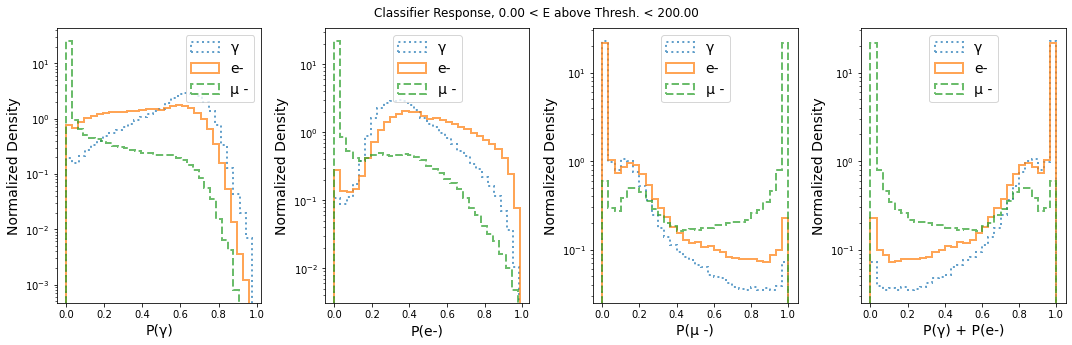

In [44]:
BIN_NUM = 1
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs,:], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])
a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

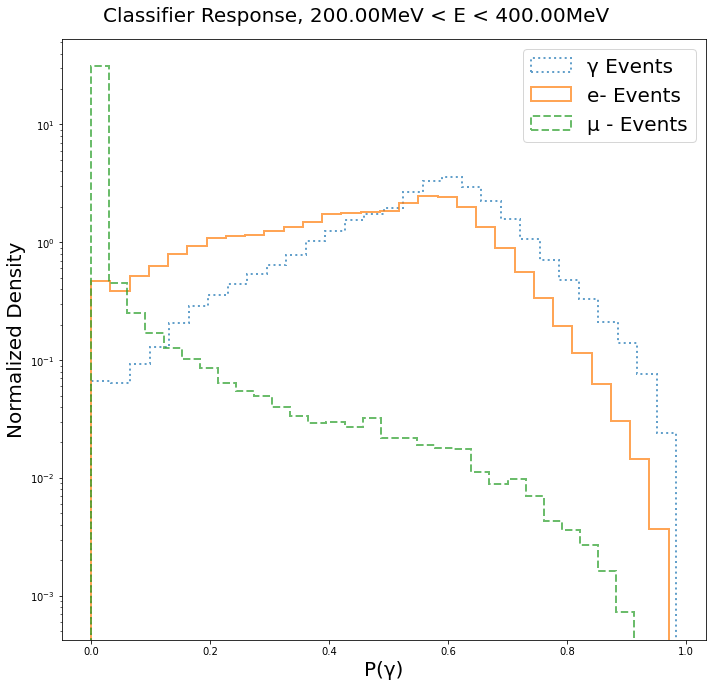

In [31]:
BIN_NUM = 2
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper right', 'upper center',
                                                                                    'upper center'],label_size=20)
a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f}MeV < E < {bins[BIN_NUM]:.2f}MeV', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("pgamma_response_e200-400.pdf")

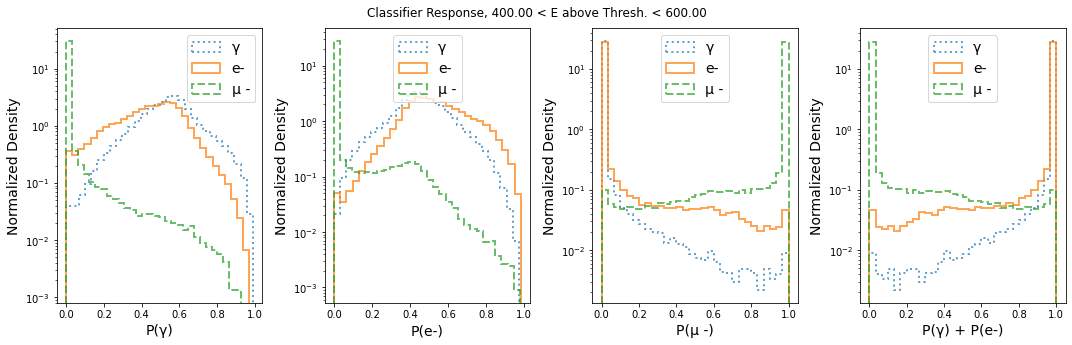

In [46]:
BIN_NUM = 3
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])
a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

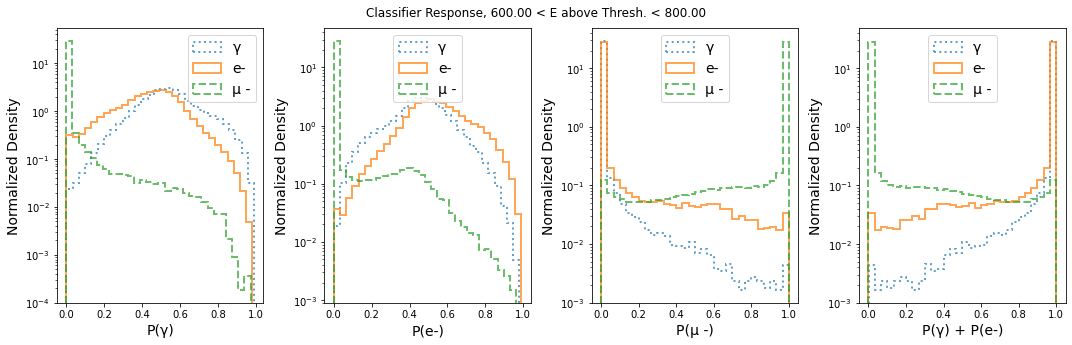

In [47]:
BIN_NUM = 4
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])
a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

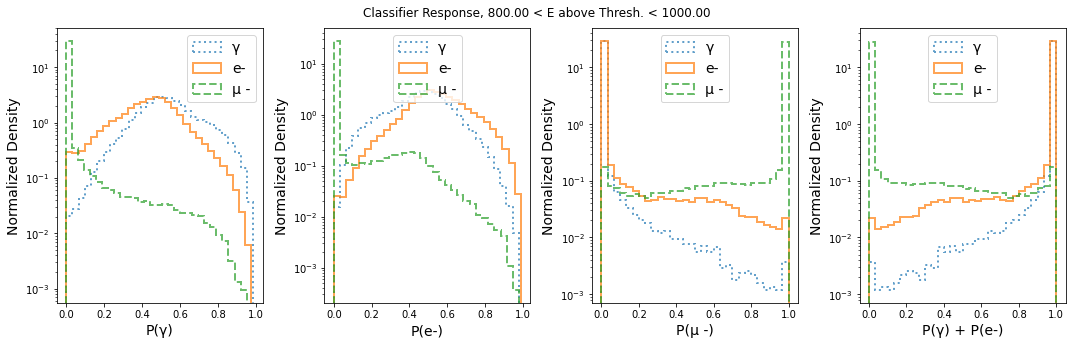

In [48]:
BIN_NUM = 5
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])
a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

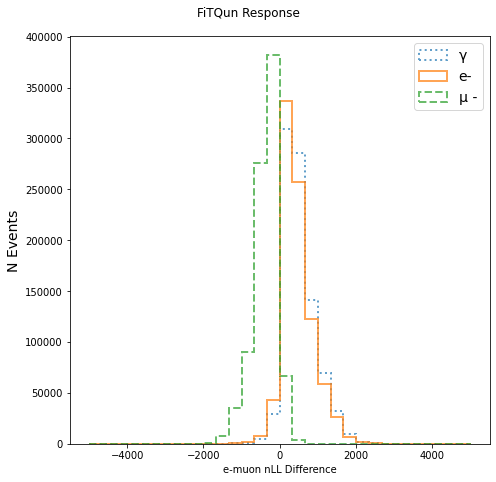

In [31]:
fig = plot_response(fq_scores, fq_labels, ['gamma','e','mu'], 
                    softmax_index_dict, linestyle=(':','-','--'), bins=30,legend_locs=['best'], fitqun=True, 
                    xlim = [-5000,5000])
a = fig.suptitle(f'FiTQun Response')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [32]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == repeat_1['filtered_labels'][i]
assert fq_labels.shape[0] == repeat_1['filtered_labels'].shape[0]

Max: 3511.31982421875 Min: -3511.31982421875


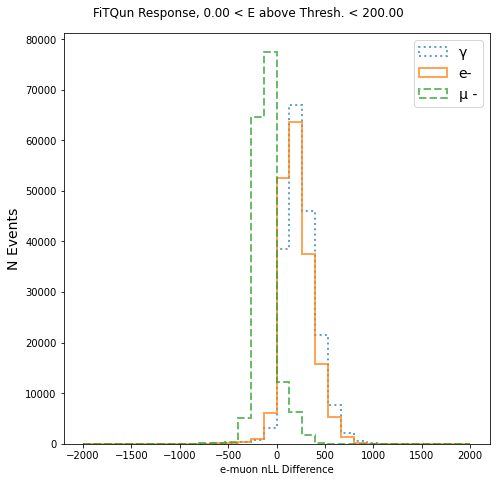

In [33]:
BIN_NUM = 1
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Max: 3645.32421875 Min: -3645.32421875


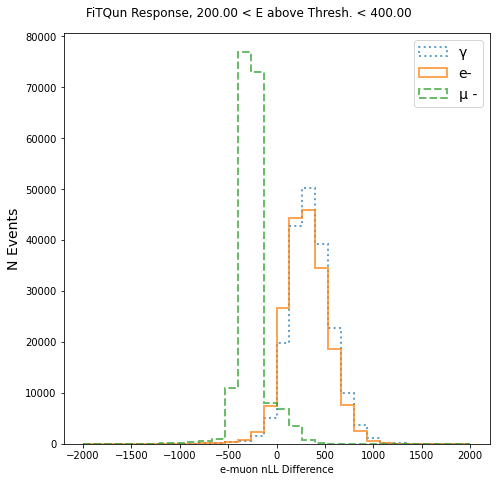

In [34]:
BIN_NUM = 2
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Max: 4641.875 Min: -4641.875


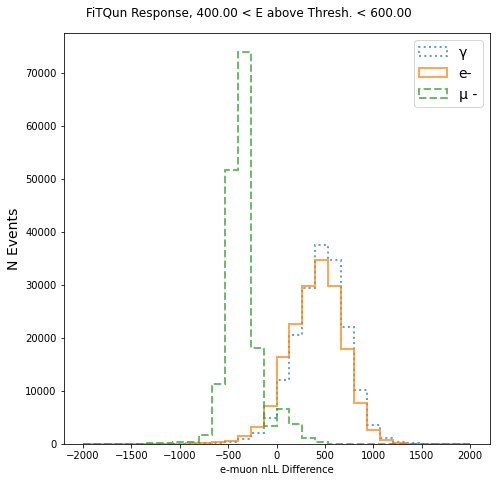

In [35]:
BIN_NUM = 3
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Max: 1.169843284911063e+17 Min: -1.169843284911063e+17


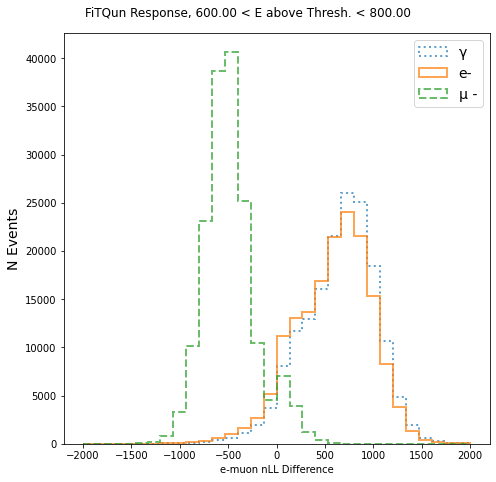

In [36]:
BIN_NUM = 4
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Max: 1.1736943243873485e+17 Min: -1.1736943243873485e+17


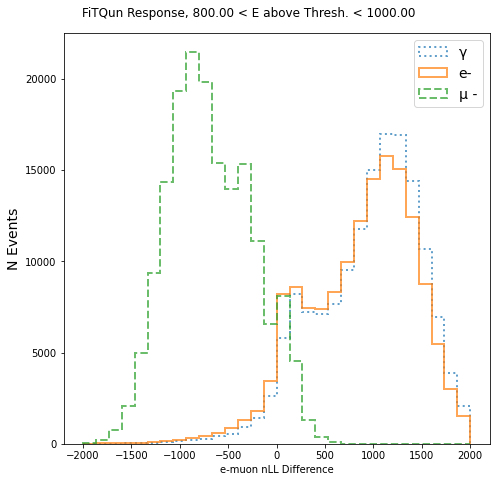

In [37]:
BIN_NUM = 5
bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),
                    legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot Binned Response

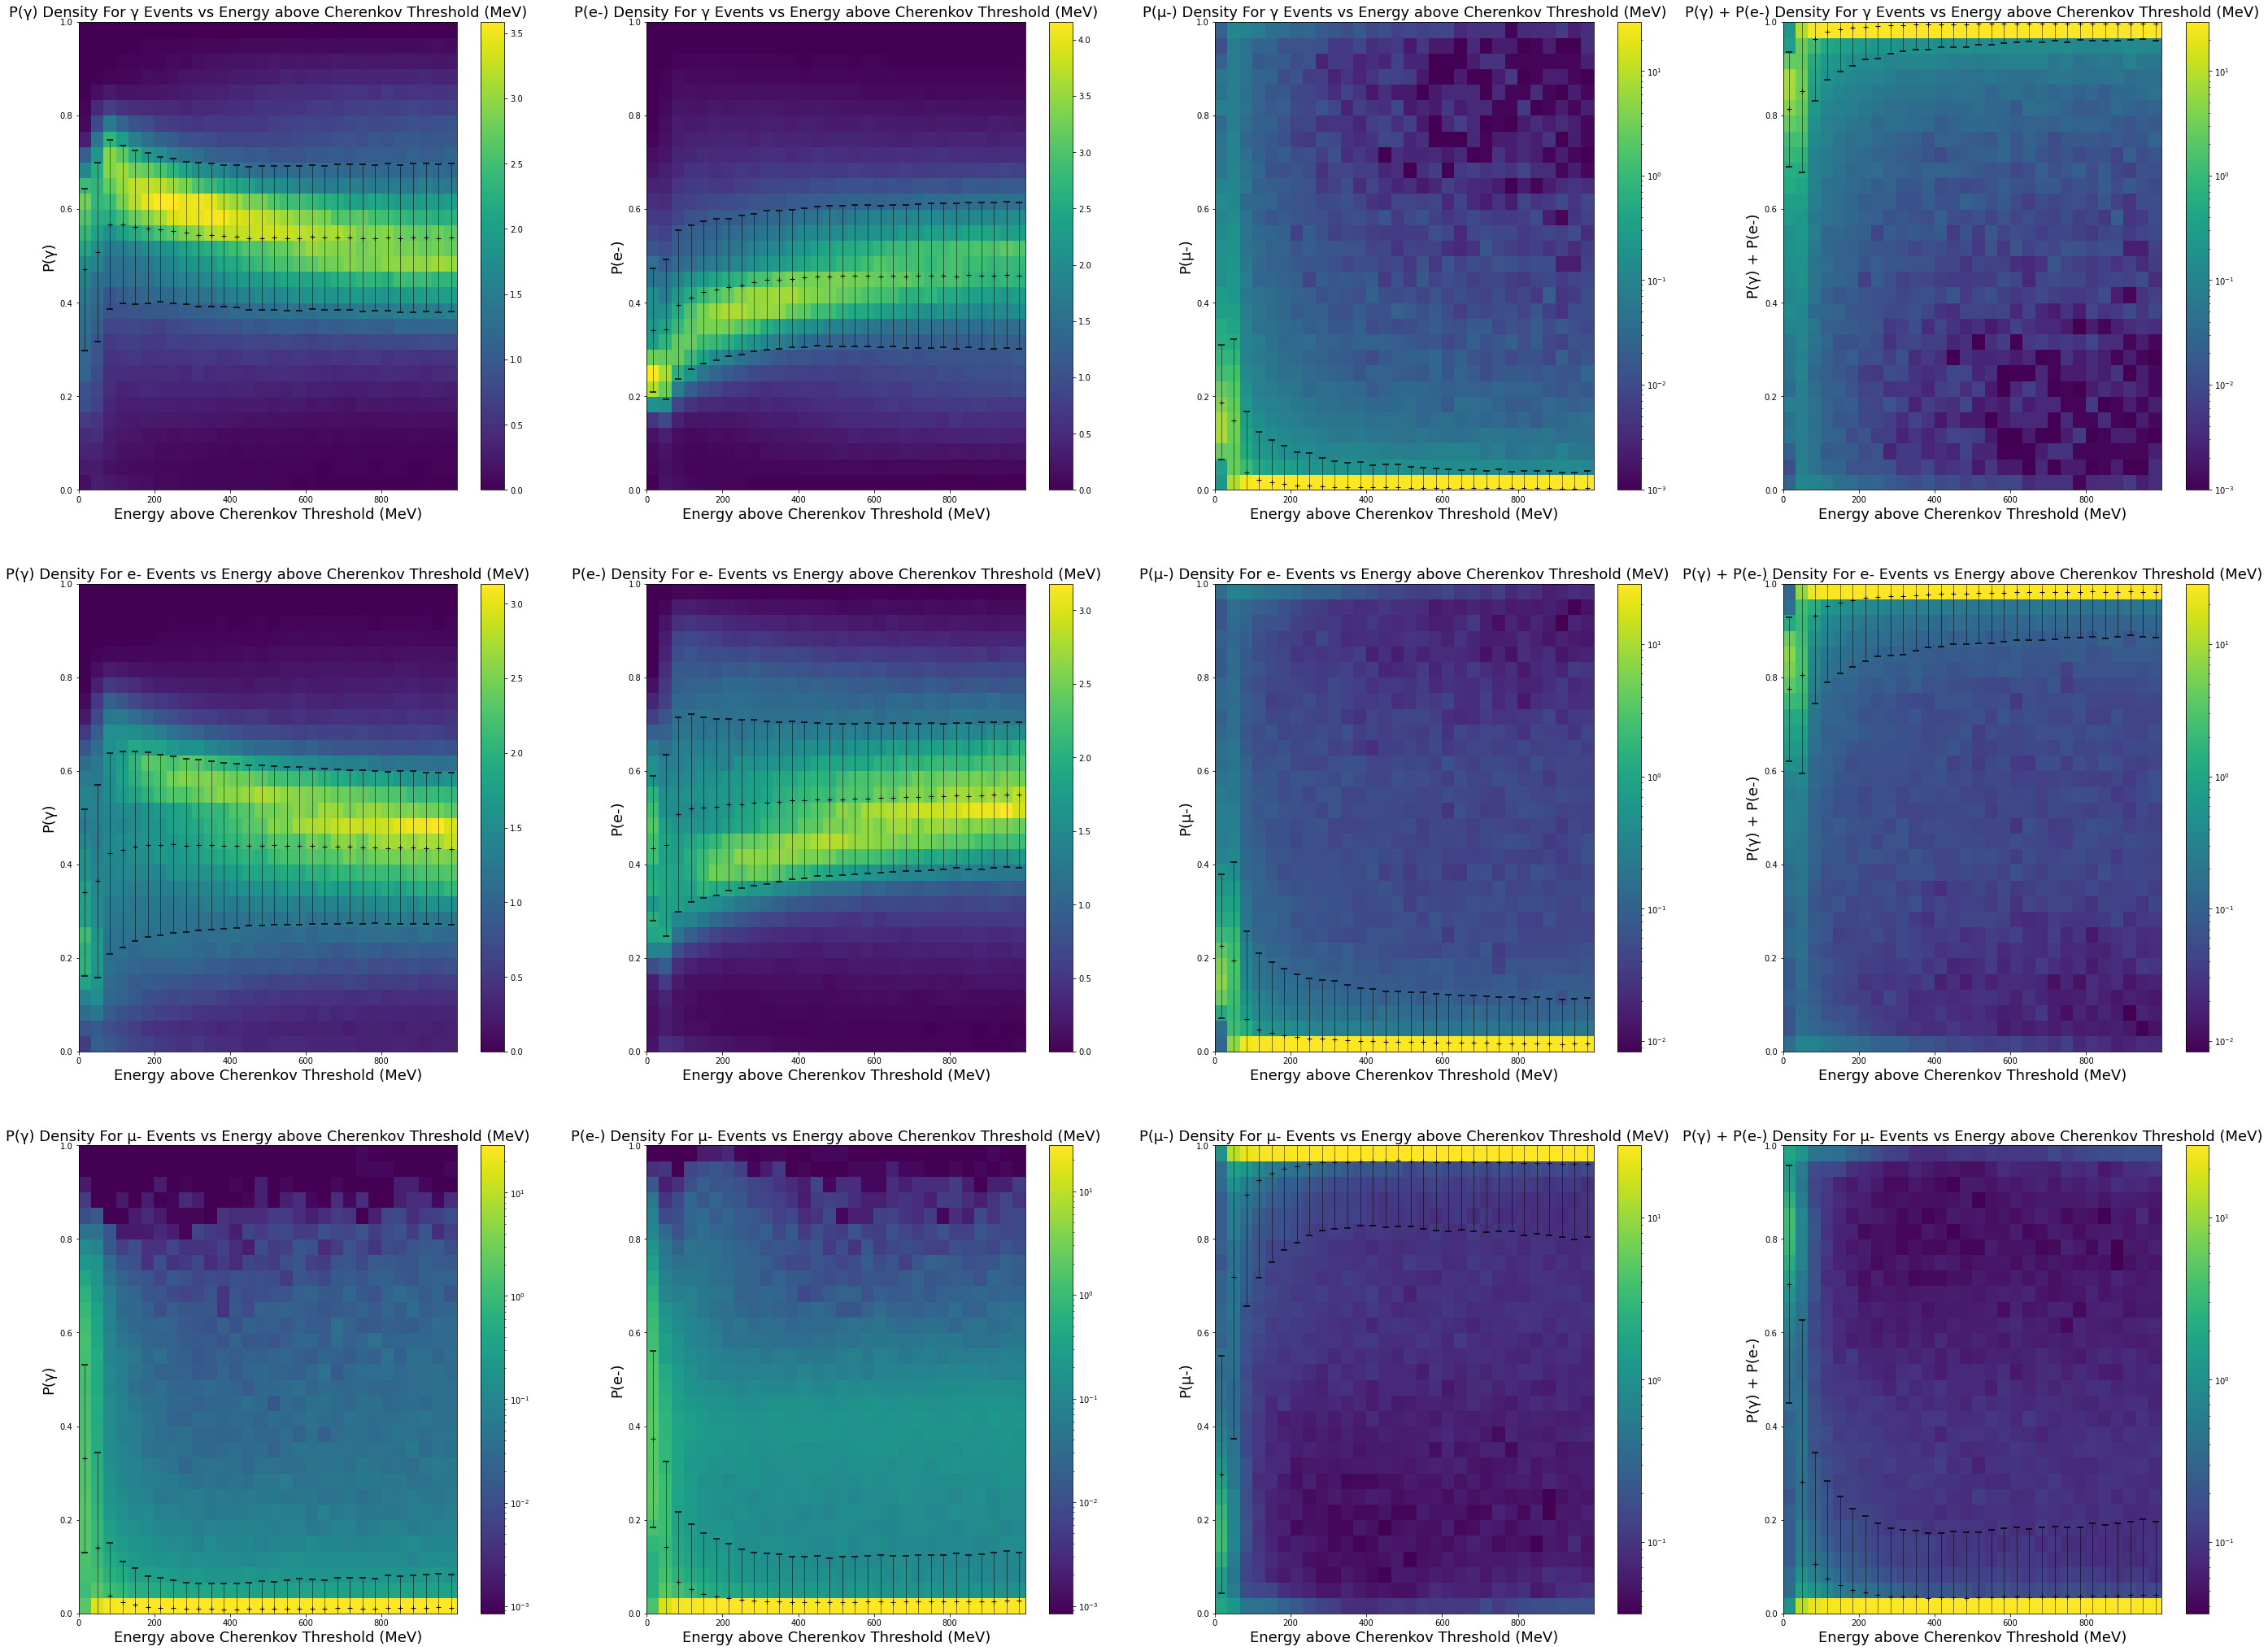

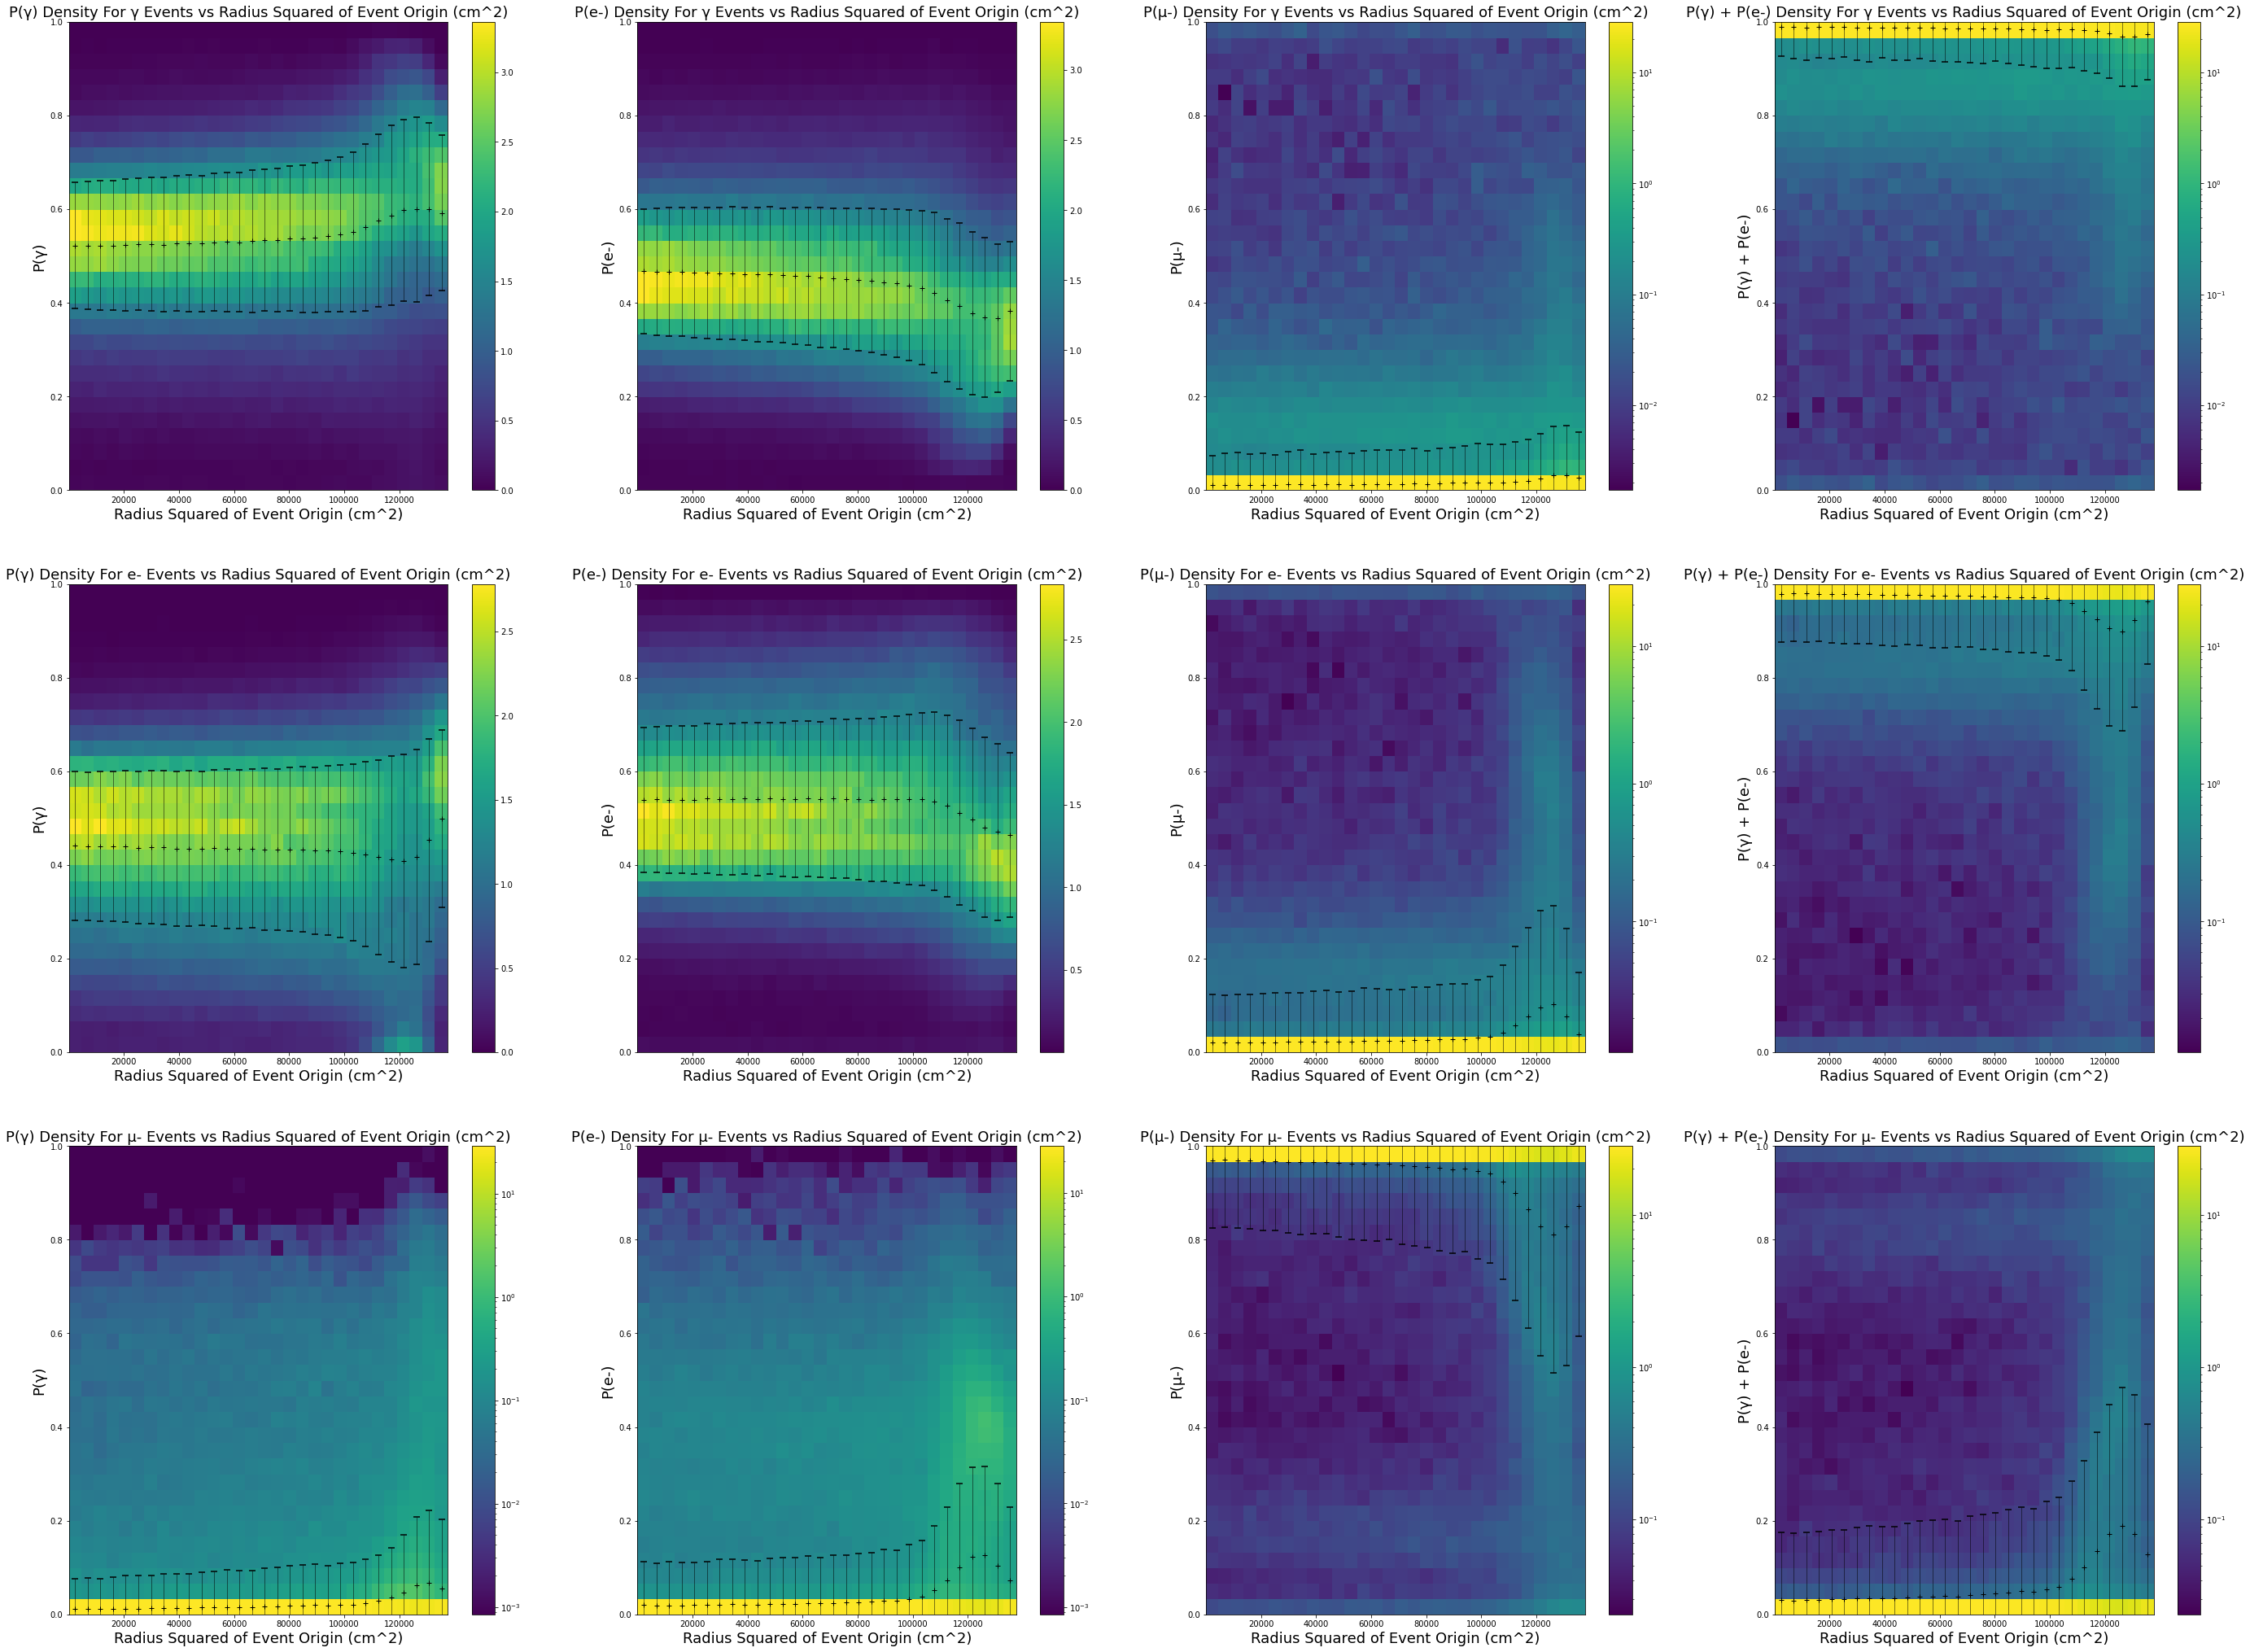

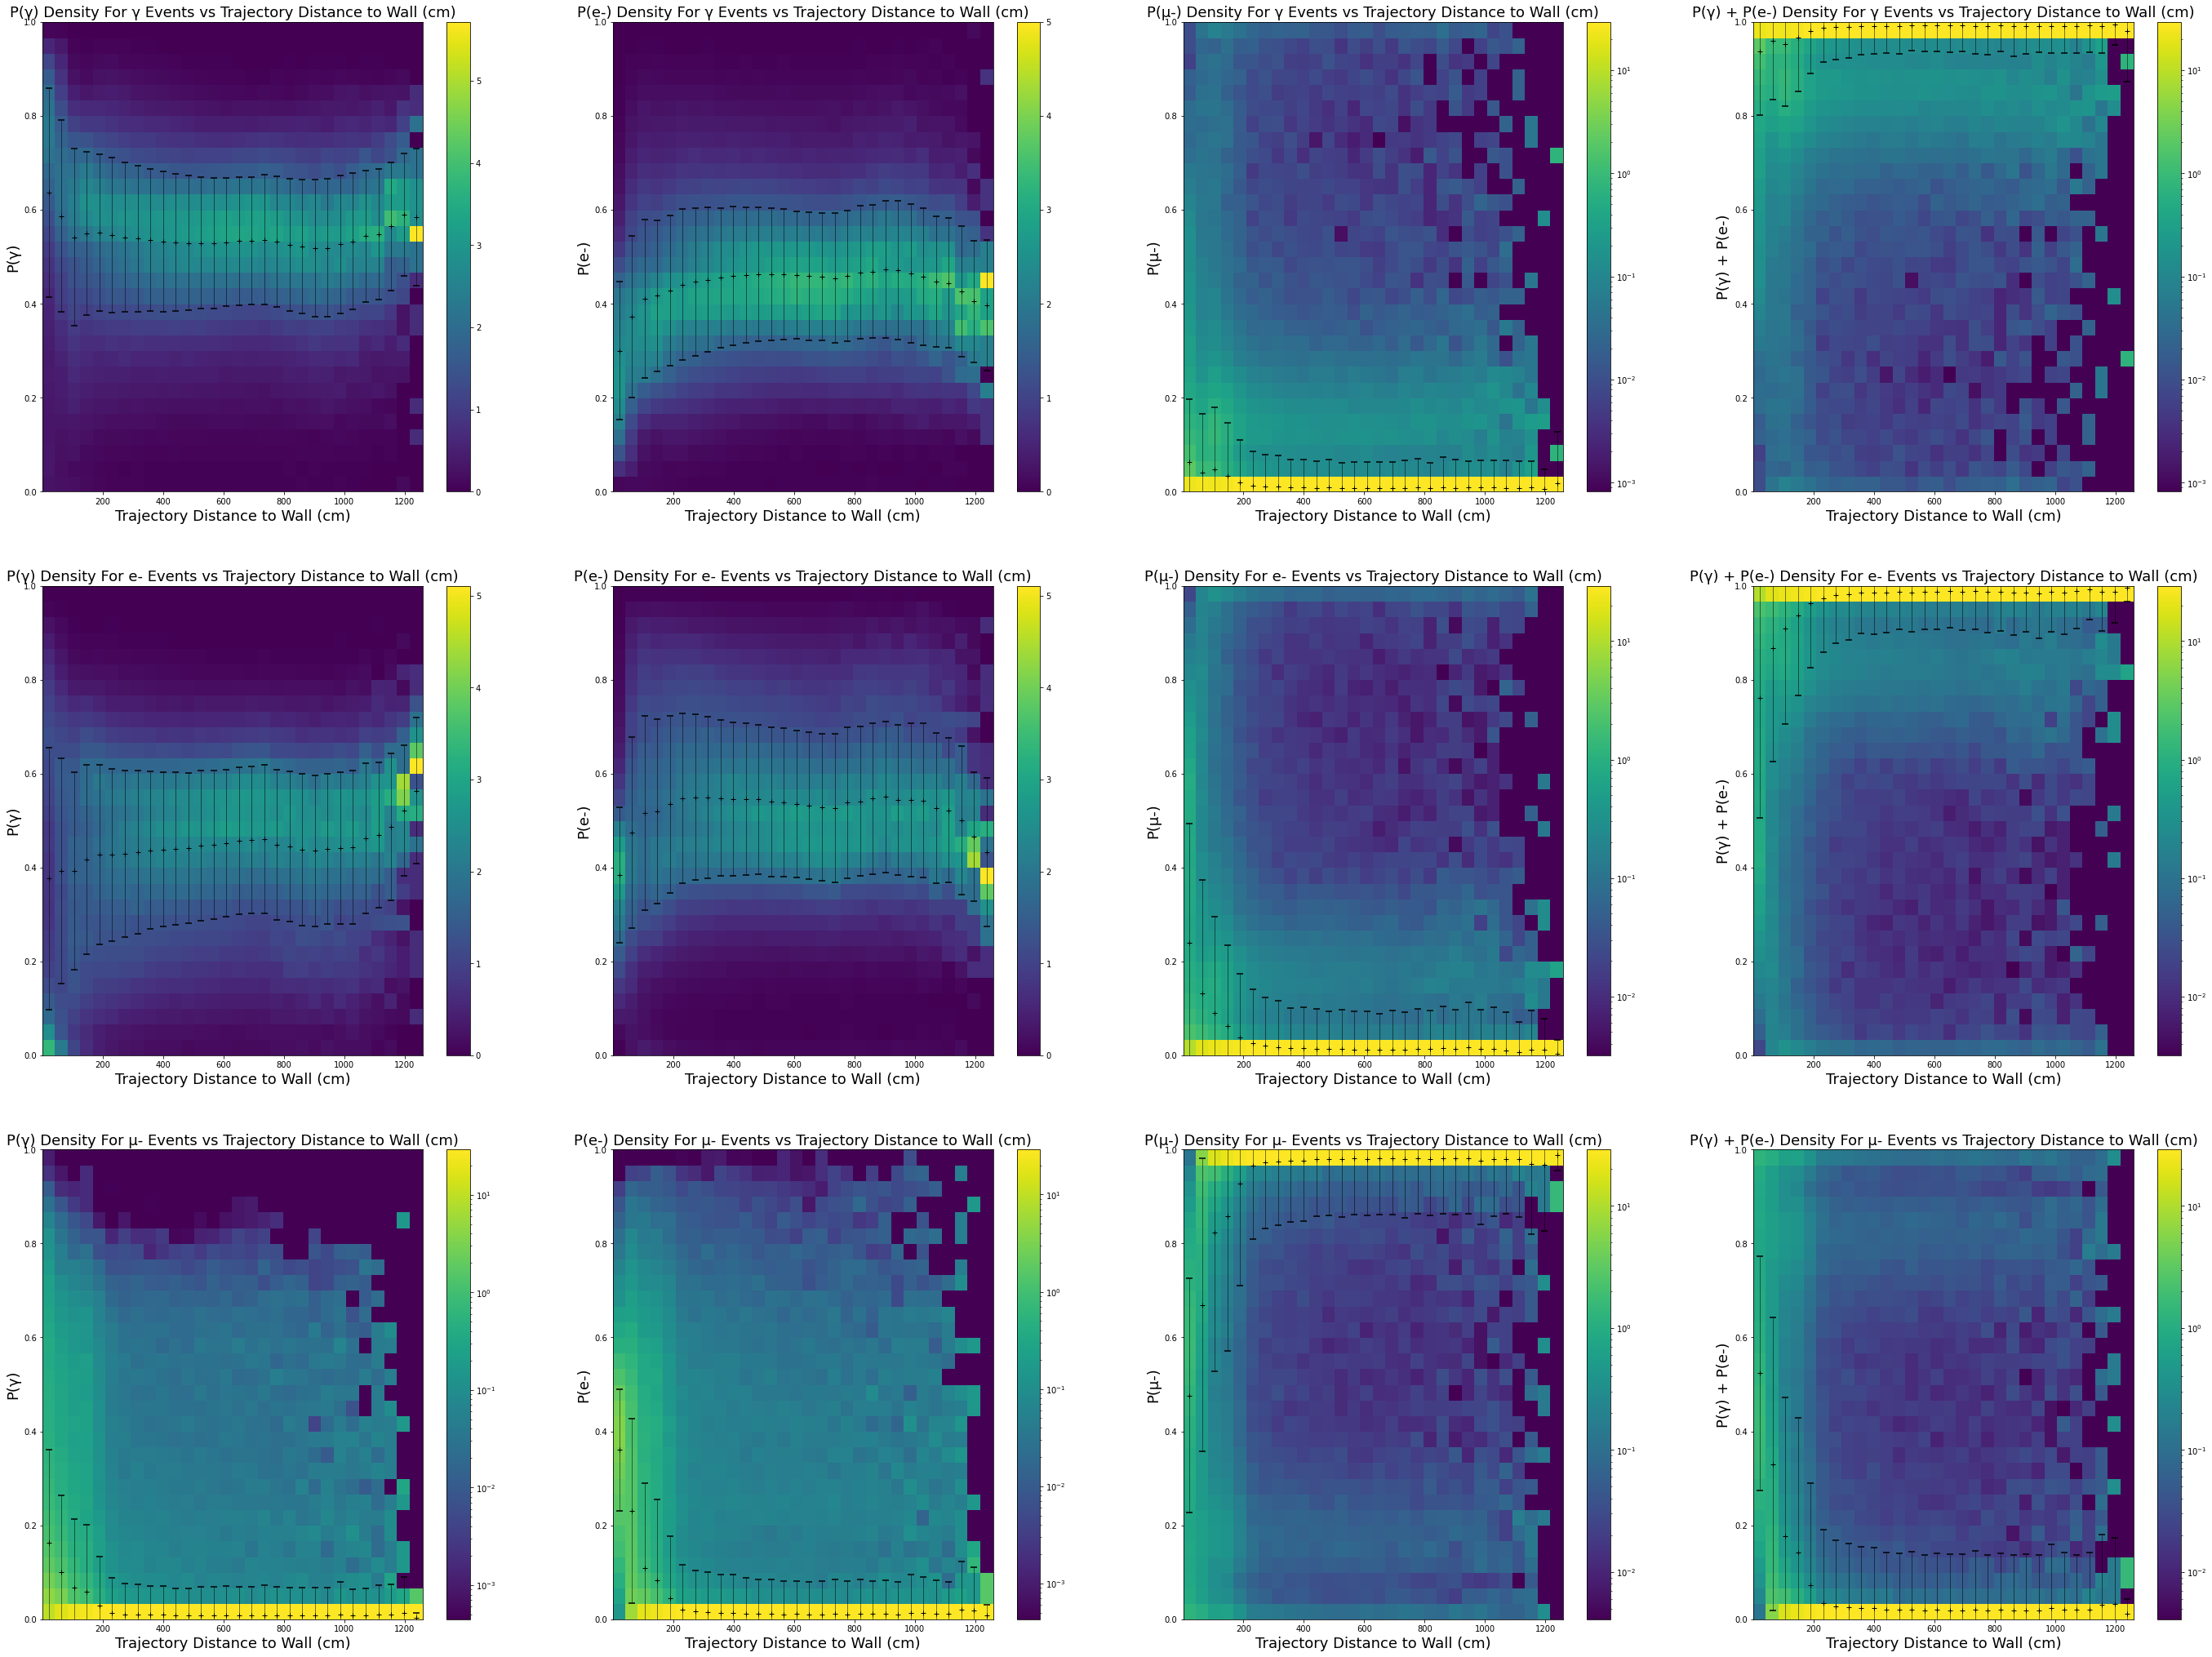

In [38]:
fig1 = plot_binned_response(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            shifted_energies,           
            'Energy above Cherenkov Threshold (MeV)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )

fig2 = plot_binned_response(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10])

fig3 = plot_binned_response(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            d_to_wall,           
            'Trajectory Distance to Wall (cm)',
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10])
